In [1]:
# Imports
import os
import numpy as np
import torch
from torch import nn
from torch import optim
from matplotlib import pyplot as plt
import matplotlib as mpl

In [2]:
# @title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# @title Data retrieval and loading

import hashlib
import requests

fname = "W3D4_stringer_oribinned6_split.npz"
url = "https://osf.io/p3aeb/download"
expected_md5 = "b3f7245c6221234a676b71a1f43c3bb5"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [4]:
# @title Plotting Functions

def show_stimulus(img, ax=None):
  """Visualize a stimulus"""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img+0.5, cmap=mpl.cm.binary)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

def plot_weights(weights, channels=[0], colorbar=True):
  """ plot convolutional channel weights
  Args:
        weights: weights of convolutional filters (conv_channels x K x K)
        channels: which conv channels to plot
  """
  wmax = torch.abs(weights).max()
  fig, axs = plt.subplots(1,len(channels), figsize=(12,2.5))
  for i, channel in enumerate(channels):
    im = axs[i].imshow(weights[channel,0], vmin=-wmax, vmax=wmax, cmap='bwr')
    axs[i].set_title('channel %d'%channel)

  if colorbar:
    ax = fig.add_axes([1, 0.1, 0.05, 0.8])
    plt.colorbar(im, ax=ax)
    ax.axis('off')

def plot_example_activations(stimuli, act, channels=[0]):
  """ plot activations act and corresponding stimulus
  Args:
        stimuli: stimulus input to convolutional layer (n x h x w) or (h x w)
        act: activations of convolutional layer (n_bins x conv_channels x n_bins)
        channels: which conv channels to plot
  """
  if stimuli.ndim>2:
    n_stimuli = stimuli.shape[0]
  else:
    stimuli = stimuli.unsqueeze(0)
    n_stimuli = 1

  fig, axs = plt.subplots(n_stimuli,1+len(channels),figsize=(12,12))

  # plot stimulus
  for i in range(n_stimuli):
    show_stimulus(stimuli[i].squeeze(), ax=axs[i, 0])
    axs[i, 0].set_title('stimulus')

    # plot example activations
    for k, (channel, ax) in enumerate(zip(channels, axs[i][1:])):
      img=ax.imshow(act[i,channel], vmin=-3, vmax=3, cmap='bwr')
      ax.set_xlabel('x-pos')
      ax.set_ylabel('y-pos')
      ax.set_title('channel %d'%channel)
  ax = fig.add_axes([1.05,0.8,0.01,0.1])
  plt.colorbar(img, cax=ax)
  ax.set_title('activation\n strength')

In [5]:
# @title Helper Functions

def load_data_split(data_name=fname):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaginge. The responses have been normalized by
  spontaneous levels of activity and then z-scored over stimuli, so
  expect negative numbers. The repsonses were split into train and
  test and then each set were averaged in bins of 6 degrees.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  It will hold out some of the trials when averaging to allow us to have test
  tuning curves.

  Args:
    data_name (str): filename to load

  Returns:
    resp_train (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    resp_test (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp_train = data['resp_train']
  resp_test = data['resp_test']
  stimuli = data['stimuli']

  # Return as torch.Tensor
  resp_train_tensor = torch.tensor(resp_train, dtype=torch.float32)
  resp_test_tensor = torch.tensor(resp_test, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli, dtype=torch.float32)

  return resp_train_tensor, resp_test_tensor, stimuli_tensor


def filters(out_channels=6, K=7):
  """ make example filters, some center-surround and gabors
  Returns:
      filters: out_channels x K x K
  """
  grid = np.linspace(-K/2, K/2, K).astype(np.float32)
  xx,yy = np.meshgrid(grid, grid, indexing='ij')

  # create center-surround filters
  sigma = 1.1
  gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*sigma**2))
  wide_gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*2)**2))
  center_surround = gaussian - 0.5 * wide_gaussian

  # create gabor filters
  thetas = np.linspace(0, 180, out_channels-2+1)[:-1] * np.pi/180
  gabors = np.zeros((len(thetas), K, K), np.float32)
  lam = 10
  phi = np.pi/2
  gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*0.4)**2))
  for i,theta in enumerate(thetas):
    x = xx*np.cos(theta) + yy*np.sin(theta)
    gabors[i] = gaussian * np.cos(2*np.pi*x/lam + phi)

  filters = np.concatenate((center_surround[np.newaxis,:,:],
                            -1*center_surround[np.newaxis,:,:],
                            gabors),
                           axis=0)
  filters /= np.abs(filters).max(axis=(1,2))[:,np.newaxis,np.newaxis]
  filters -= filters.mean(axis=(1,2))[:,np.newaxis,np.newaxis]
  # convert to torch
  filters = torch.from_numpy(filters)
  # add channel axis
  filters = filters.unsqueeze(1)

  return filters


def grating(angle, sf=1 / 28, res=0.1, patch=False):
  """Generate oriented grating stimulus

  Args:
    angle (float): orientation of grating (angle from vertical), in degrees
    sf (float): controls spatial frequency of the grating
    res (float): resolution of image. Smaller values will make the image
      smaller in terms of pixels. res=1.0 corresponds to 640 x 480 pixels.
    patch (boolean): set to True to make the grating a localized
      patch on the left side of the image. If False, then the
      grating occupies the full image.

  Returns:
    torch.Tensor: (res * 480) x (res * 640) pixel oriented grating image

  """

  angle = np.deg2rad(angle)  # transform to radians

  wpix, hpix = 640, 480  # width and height of image in pixels for res=1.0

  xx, yy = np.meshgrid(sf * np.arange(0, wpix * res) / res, sf * np.arange(0, hpix * res) / res)

  if patch:
    gratings = np.cos(xx * np.cos(angle + .1) + yy * np.sin(angle + .1))  # phase shift to make it better fit within patch
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1
    xcent = gratings.shape[1] * .75
    ycent = gratings.shape[0] / 2
    xxc, yyc = np.meshgrid(np.arange(0, gratings.shape[1]), np.arange(0, gratings.shape[0]))
    icirc = ((xxc - xcent) ** 2 + (yyc - ycent) ** 2) ** 0.5 < wpix / 3 / 2 * res
    gratings[~icirc] = 0.5

  else:
    gratings = np.cos(xx * np.cos(angle) + yy * np.sin(angle))
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1

  gratings -= 0.5

  # Return torch tensor
  return torch.tensor(gratings, dtype=torch.float32)

stimulus size: 48 x 64


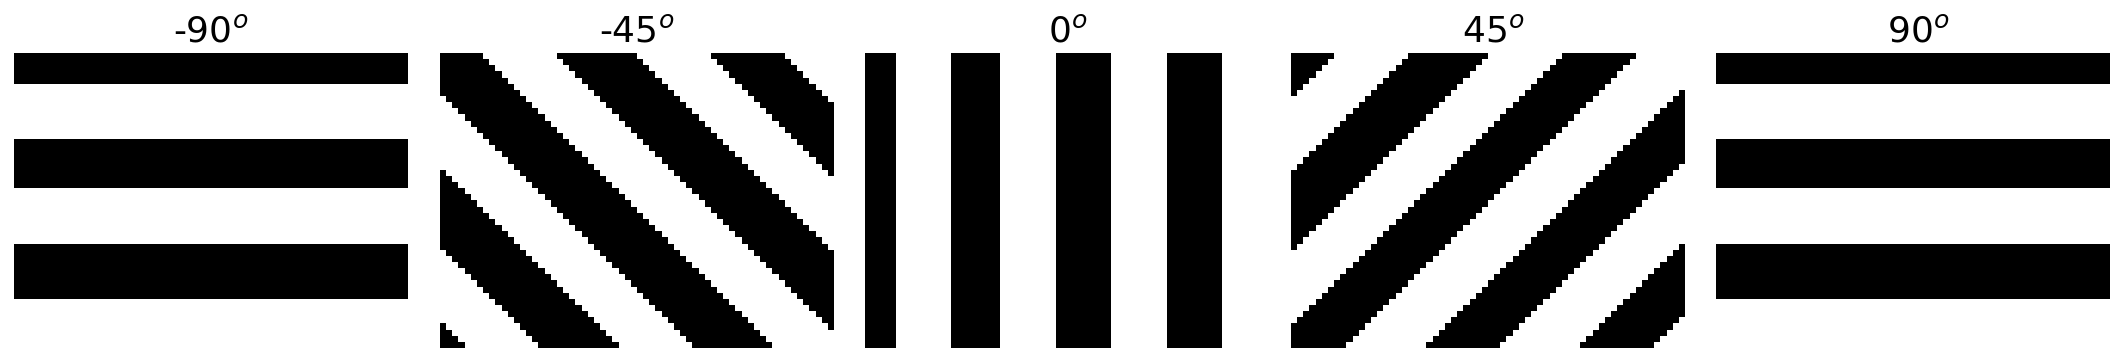

In [6]:
# @markdown Execute this cell to plot example stimuli

orientations = np.linspace(-90, 90, 5)

h = 3
n_col = len(orientations)
fig, axs = plt.subplots(1, n_col, figsize=(h * n_col, h))

h, w  = grating(0).shape  # height and width of stimulus
print('stimulus size: %i x %i' % (h, w))

for i, ori in enumerate(orientations):
  stimulus = grating(ori)
  axs[i].set_title(f'{ori: .0f}$^o$')
  show_stimulus(stimulus, axs[i])

In [7]:
class ConvolutionalLayer(nn.Module):
  """Deep network with one convolutional layer
     Attributes: conv (nn.Conv2d): convolutional layer
  """
  def __init__(self, c_in=1, c_out=6, K=7, filters=None):
    """Initialize layer

    Args:
        c_in: number of input stimulus channels
        c_out: number of output convolutional channels
        K: size of each convolutional filter
        filters: (optional) initialize the convolutional weights

    """
    super().__init__()
    self.conv = nn.Conv2d(c_in, c_out, kernel_size=K,
                          padding=K//2, stride=1)
    if filters is not None:
      self.conv.weight = nn.Parameter(filters)
      self.conv.bias = nn.Parameter(torch.zeros((c_out,), dtype=torch.float32))

  def forward(self, s):
    """Run stimulus through convolutional layer

    Args:
        s (torch.Tensor): n_stimuli x c_in x h x w tensor with stimuli

    Returns:
        (torch.Tensor): n_stimuli x c_out x h x w tensor with convolutional layer unit activations.

    """
    a = self.conv(s)  # output of convolutional layer

    return a

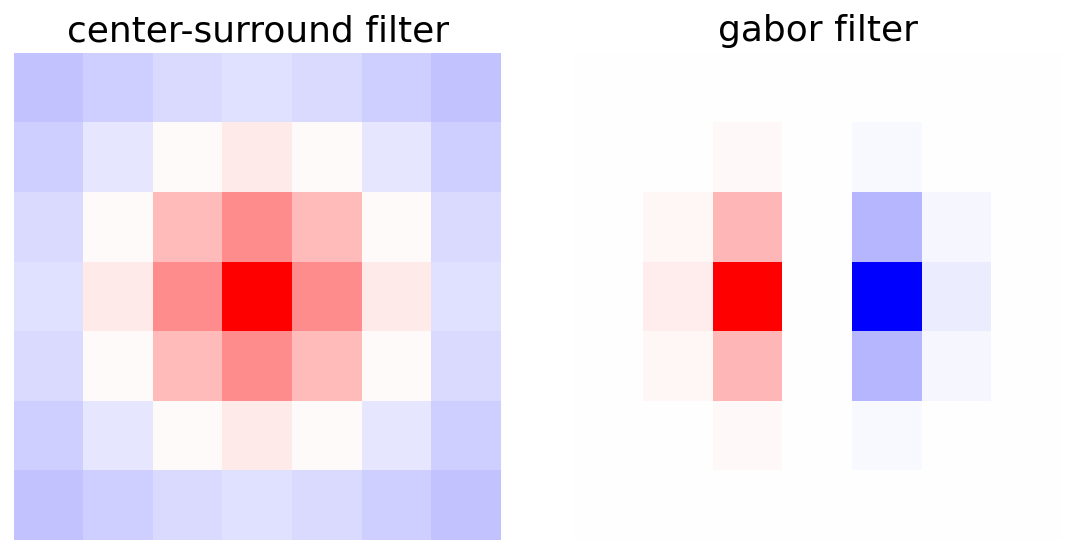

In [8]:
# @markdown Execute this cell to create and visualize filters

example_filters = filters(out_channels=6, K=7)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(example_filters[0,0], vmin=-1, vmax=1, cmap='bwr')
plt.title('center-surround filter')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(example_filters[4,0], vmin=-1, vmax=1, cmap='bwr')
plt.title('gabor filter')
plt.axis('off');

C:\Users\19562\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


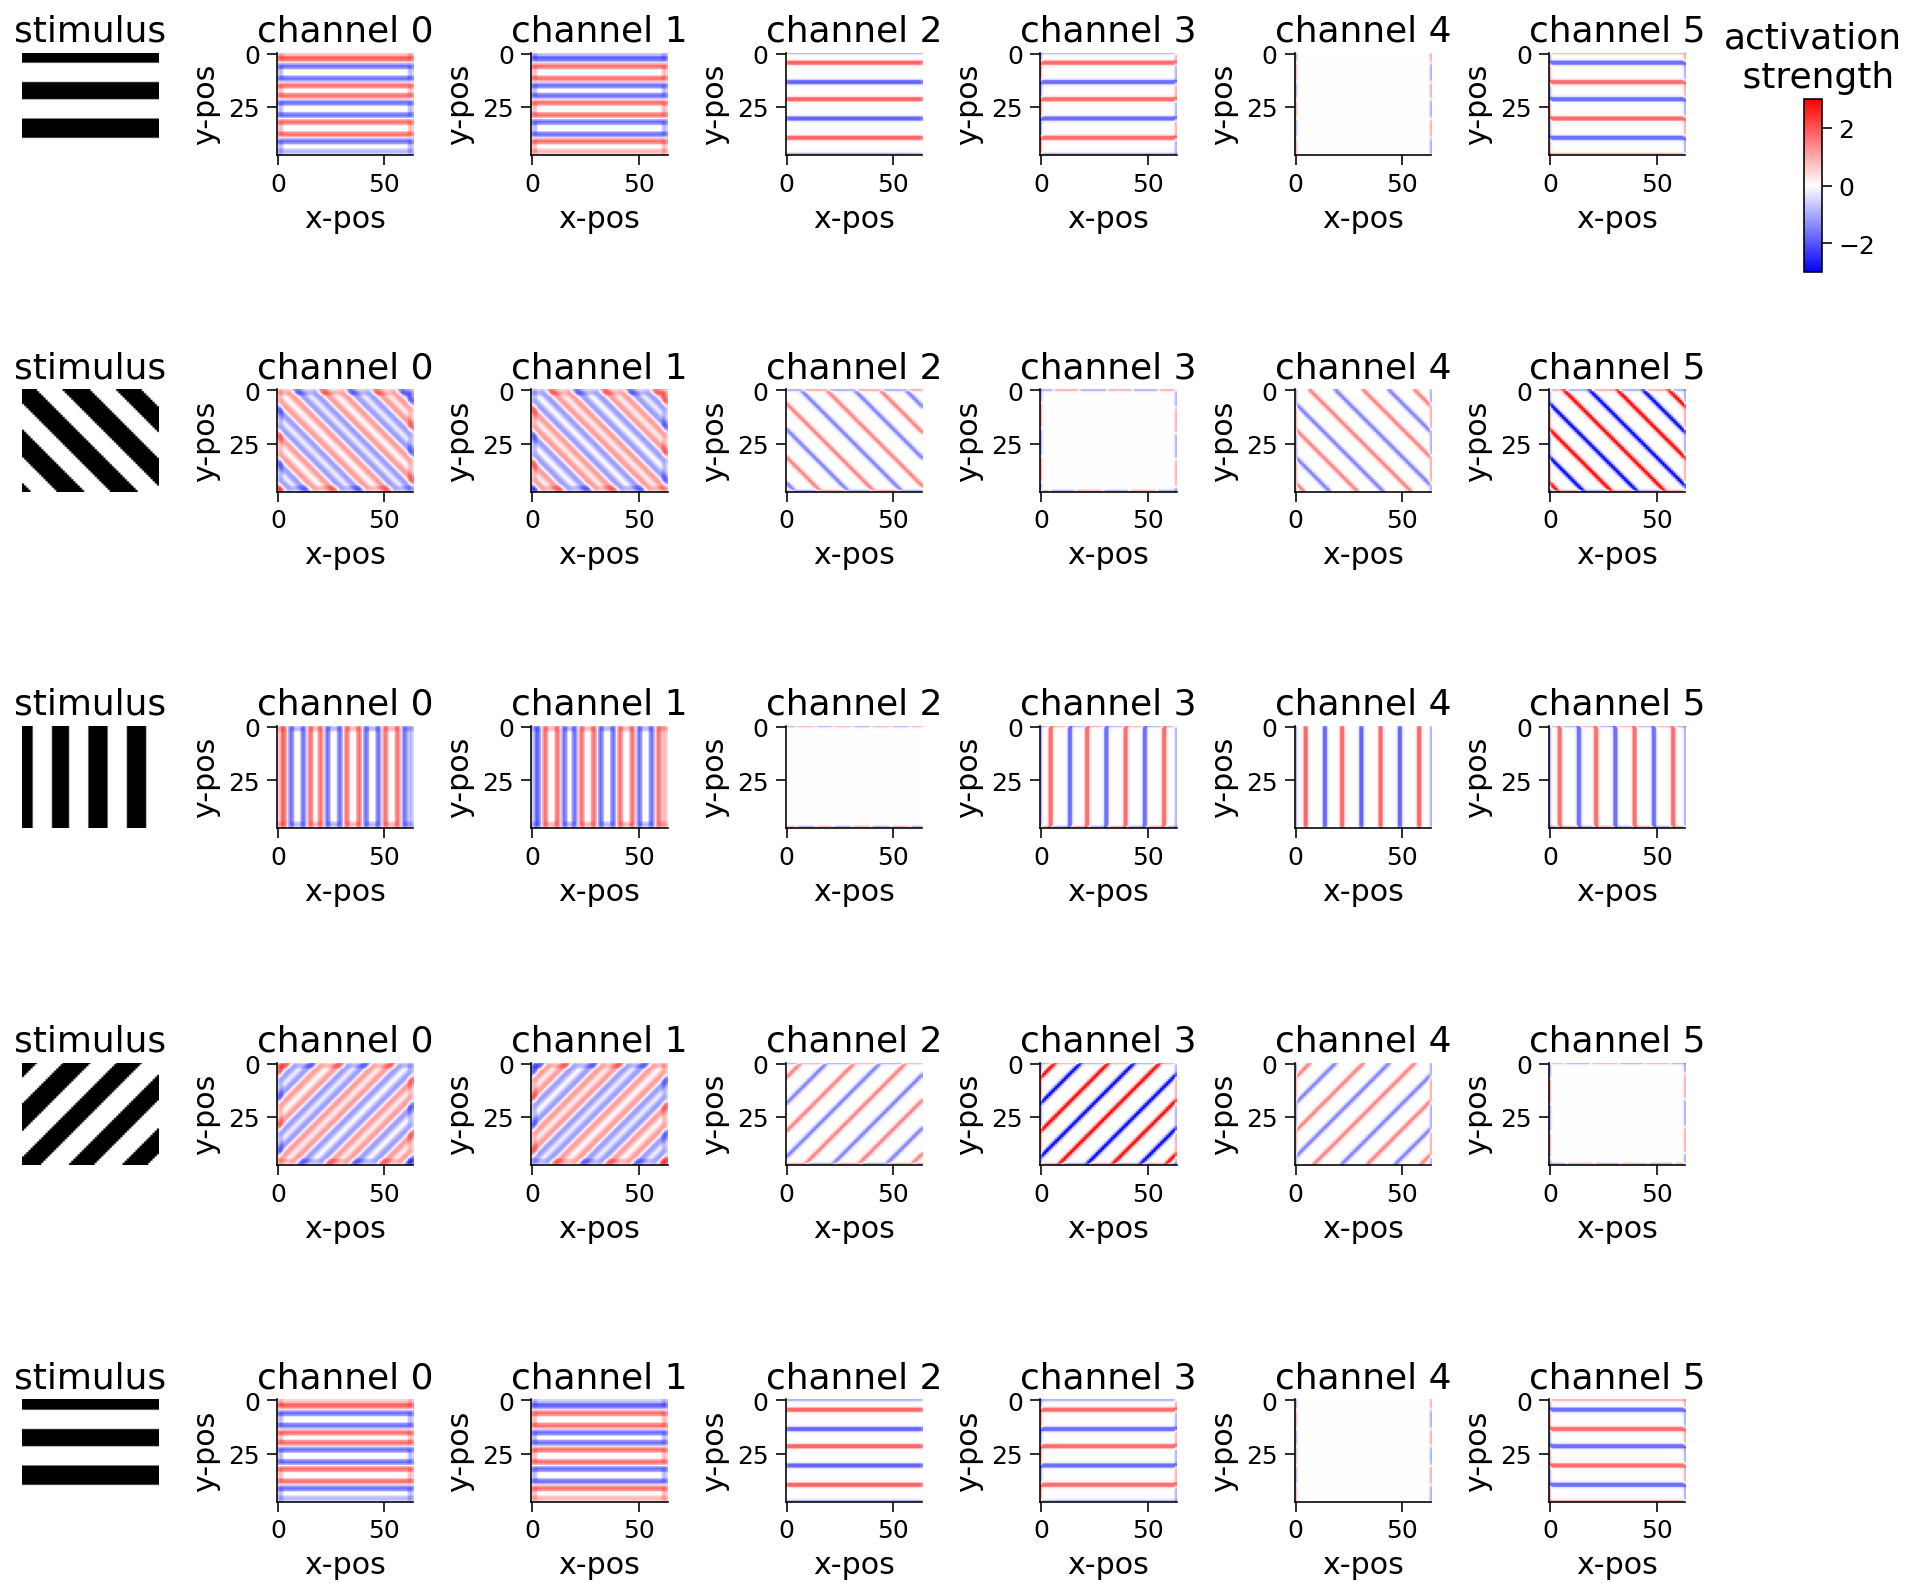

In [10]:
# Stimulus parameters
in_channels = 1 # how many input channels in our images
h = 48 # height of images
w = 64 # width of images

# Convolution layer parameters
K = 7 # filter size
out_channels = 6 # how many convolutional channels to have in our layer
example_filters = filters(out_channels, K) # create filters to use

convout = np.zeros(0) # assign convolutional activations to convout

################################################################################
## TODO for students: create convolutional layer in pytorch
# Complete and uncomment
#raise NotImplementedError("Student exercise: create convolutional layer")
################################################################################

# Initialize conv layer and add weights from function filters
# you need to specify :
# * the number of input channels c_in
# * the number of output channels c_out
# * the filter size K
convLayer = ConvolutionalLayer(in_channels,out_channels, K, filters=example_filters)

# Create stimuli (H_in, W_in)
orientations = [-90, -45, 0, 45, 90]
stimuli = torch.zeros((len(orientations), in_channels, h, w), dtype=torch.float32)
for i,ori in enumerate(orientations):
  stimuli[i,0] = grating(ori)

convout = convLayer(stimuli)
convout = convout.detach() # detach gradients

plot_example_activations(stimuli, convout, channels=np.arange(0, out_channels))